# Post-processing neural weather models improves the prediction of convective storm wind gusts

This notebook aims at presenting how to use the code coming with the article. It also provides code used to create the figures in the article.

In [1]:
# Importing needed libraries and functions
import xarray as xr
import numpy as np
import pickle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

## Loading the different models

Four different post-processing models are compared in the article:
- a Convolutional Neural Network
- an Artificial Neural Network
- a Vision Transformer
- a Vector Generalized Linear Model

Additional models to evaluate the performance of the preceding one include:
- a _persistant model_: prediction for time $t + \Delta t$ is observation at time $t$.
- a _climatology_: predicted distribution for any time on test year 2021 is climatology from train years 2016 to 2020.
- ERA5-based post-processing models: instead of post-processing Pangu outputs, the four preceding models are trained directly on ERA5 at time $t$ to predict wind gust distribution at time $t + \Delta t$.
- a _COSMO_ model, which serves as a benchmark, being the most accurate model against which the post-processing models can compete.

CRPS of each model were calculated during training for each cluster, each time step on test set (i.e. year 2021). The following notebook uses said CRPS arrays to create the different figures for the article.

In [147]:
# Load the data from data folder
lead_times = pickle.load(open('./data/lead_times.pkl', 'rb'))
stations = pickle.load(open('./data/stations.pkl', 'rb'))
i_clusters = pickle.load(open('./data/i_clusters.pkl', 'rb'))
t_array = pickle.load(open('./data/t_array.pkl', 'rb'))
ref_dates = pickle.load(open('./data/ref_dates.pkl', 'rb'))
target_dates = pickle.load(open('./data/target_dates.pkl', 'rb'))
long_crps_cnn = pickle.load(open('./data/long_crps_cnn.pkl', 'rb'))
long_crps_vit = pickle.load(open('./data/long_crps_vit.pkl', 'rb'))
long_crps_ann = pickle.load(open('./data/long_crps_ann.pkl', 'rb'))
long_crps_vgam = pickle.load(open('./data/long_crps_vgam.pkl', 'rb'))
long_crps_baseline = pickle.load(open('./data/long_crps_baseline.pkl', 'rb'))
long_crps_persistant = pickle.load(open('./data/long_crps_persistant.pkl', 'rb'))
long_crps_best_possible = pickle.load(open('./data/long_crps_best_possible.pkl', 'rb'))

crps_icon = pickle.load(open('./data/crps_icon.pkl', 'rb'))

crps_pangu_era5 = pickle.load(open('./data/crps_pangu_era5.pkl', 'rb'))

crpss_max_winds = pickle.load(open('./data/crpss_max_winds.pkl', 'rb'))

shap_ds = xr.open_dataset('./data/shap_ds.nc')

## Fig 1 : Workflow

![title](data/workflow.png)

Pangu-Weather forecasts for a day with convective conditions are clipped to Switzerland and post-processed using one of our different models. The best results are obtained with the CNN, which takes entire maps of features as input. 5 different Generalised Extreme Value distributions are created, one for each cluster. This example shows predictions for June 2\textsuperscript{nd}, 2021 at 17:00 with a lead time of 27 h. Accuracy varies with the prediction (e.g., forecast for cluster 2 is less accurate than for cluster 4.

## Fig 2 : General performance of post-processing models across lead times against direct forecast and ICON model


In [3]:
crps_cnn_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)
crps_vgam_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)
crps_ann_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)
crps_vit_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)
crps_baseline_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)
crps_best_possible_ref = np.full((5,5,len(ref_dates),len(lead_times)), np.nan)

for i_lt, lead_time in enumerate(lead_times):
    for i_rd, ref_date in enumerate(ref_dates):
        target_date = ref_date + pd.to_timedelta(lead_time, unit = 'h')
        if target_date in target_dates:
            
            i_d = np.argwhere(target_dates == target_date)[0][0]+339*i_lt
            crps_cnn_ref[:,:,i_rd,i_lt] = long_crps_cnn[:,:,i_d]
            crps_ann_ref[:,:,i_rd,i_lt] = long_crps_ann[:,:,i_d]
            crps_vit_ref[:,:,i_rd,i_lt] = long_crps_vit[:,:,i_d]
            crps_vgam_ref[:,:,i_rd,i_lt] = long_crps_vgam[:,:,i_d]
            crps_baseline_ref[:,:,i_rd,i_lt] = long_crps_baseline[:,:,i_d]
            crps_best_possible_ref[:,:,i_rd,i_lt] = long_crps_best_possible[:,:,i_d]
mask_cnn = np.any(np.isnan(crps_cnn_ref), axis = 0, keepdims = True)
mask_ann = np.any(np.isnan(crps_ann_ref), axis = 0, keepdims = True)
mask_vit = np.any(np.isnan(crps_vit_ref), axis = 0, keepdims = True)
mask_vgam = np.any(np.isnan(crps_vgam_ref), axis = 0, keepdims = True)
mask_baseline = np.any(np.isnan(crps_baseline_ref), axis = 0, keepdims = True)
mask_best_possible = np.any(np.isnan(crps_best_possible_ref), axis = 0, keepdims = True)
mask = np.logical_or(mask_cnn, mask_ann)
mask = np.logical_or(mask, mask_vit)
mask = np.logical_or(mask, mask_vgam)
mask = np.logical_or(mask, mask_baseline)
mask = np.logical_or(mask, mask_best_possible)

mask_5fold = np.tile(mask, (5,1,1,1))
mask_21fold = np.tile(mask, (21,1,1,1))

crps_cnn_ref = np.where(mask, np.nan, crps_cnn_ref)
crps_ann_ref = np.where(mask, np.nan, crps_ann_ref)
crps_vit_ref = np.where(mask, np.nan, crps_vit_ref)
crps_vgam_ref = np.where(mask, np.nan, crps_vgam_ref)
crps_baseline_ref = np.where(mask, np.nan, crps_baseline_ref)
crps_best_possible_ref = np.where(mask, np.nan, crps_best_possible_ref)


crps_cnn = np.nanmean(crps_cnn_ref, axis = (1,2))
crps_vit = np.nanmean(crps_vit_ref, axis = (1,2))
crps_ann = np.nanmean(crps_ann_ref, axis = (1,2))
crps_vgam = np.nanmean(crps_vgam_ref, axis = (1,2))
crps_baseline = np.nanmean(crps_baseline_ref, axis = (1,2))
crps_best_possible = np.nanmean(crps_best_possible_ref, axis = (1,2))

crpss_cnn = (crps_cnn - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_vit = (crps_vit - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_ann = (crps_ann - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_vgam = (crps_vgam - crps_baseline)/(crps_best_possible - crps_baseline)


crpss_icon = (crps_icon - np.tile(crps_baseline[[1]], (21,1)))/(np.tile(crps_best_possible[[1]], (21,1)) - np.tile(crps_baseline[[1]], (21,1)))

# Create one DataArray per crpss
crpss_cnn_da = xr.DataArray(crpss_cnn,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_ann_da = xr.DataArray(crpss_ann,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_vit_da = xr.DataArray(crpss_vit,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_vgam_da = xr.DataArray(crpss_vgam,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_icon_da = xr.DataArray(crpss_icon,
                            coords = {'realisation': range(21),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')

# Create a giant pd.DataFrame, adding a supplementary column which is the name of each model
crpss_cnn_df = crpss_cnn_da.to_dataframe()
crpss_cnn_df['Model'] = 'CNN'
crpss_ann_df = crpss_ann_da.to_dataframe()
crpss_ann_df['Model'] = 'ANN'
crpss_vit_df = crpss_vit_da.to_dataframe()
crpss_vit_df['Model'] = 'ViT'
crpss_vgam_df = crpss_vgam_da.to_dataframe()
crpss_vgam_df['Model'] = 'VGAM'
crpss_icon_df = crpss_icon_da.to_dataframe()
crpss_icon_df['Model'] = 'ICON'

crpss_df = pd.concat([crpss_cnn_df, crpss_ann_df, crpss_vit_df, crpss_vgam_df, crpss_icon_df])
# Make the lead time a column instead of an index
crpss_df.reset_index(inplace = True)
# Make the lead time a float instead of a timedelta
crpss_df['lead_time'] = crpss_df['lead_time'].dt.total_seconds() / 3600



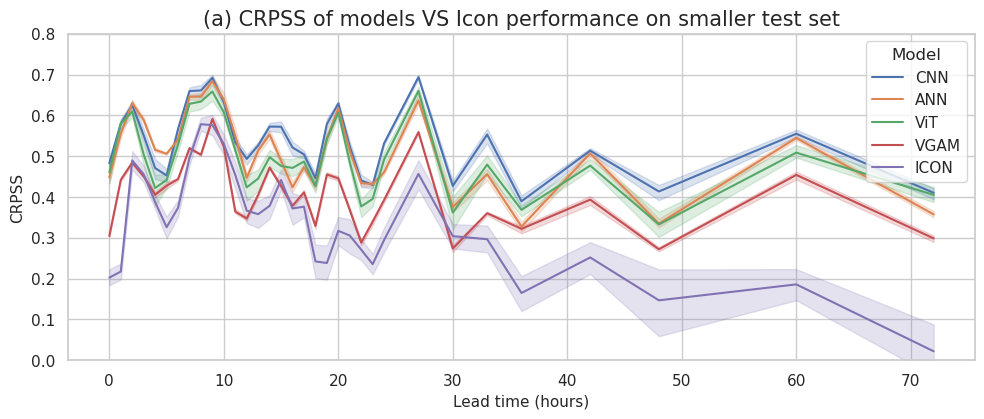

In [4]:
# Plot the CRPSS, with lead time in hours as x-axis

sns.set_theme(style = 'whitegrid')
plt.figure(figsize = (11.7, 4.24))
sns.lineplot(data = crpss_df, x = 'lead_time', y = 'CRPSS', hue = 'Model')
plt.xlabel('Lead time (hours)', fontsize = 11)
plt.ylim(0.,0.8)
plt.ylabel('CRPSS', fontsize = 11)
plt.title('(a) CRPSS of models VS Icon performance on smaller test set', fontsize = 15)
plt.tick_params(axis='both', labelsize=11)
plt.show()

In [5]:

crps_cnn = long_crps_cnn.reshape((5,5,33,-1))
crps_vit = long_crps_vit.reshape((5,5,33,-1))
crps_ann = long_crps_ann.reshape((5,5,33,-1))
crps_vgam = long_crps_vgam.reshape((5,5,33,-1))
crps_baseline = long_crps_baseline.reshape((5,5,33,-1))
crps_best_possible = long_crps_best_possible.reshape((5,5,33,-1))

crps_cnn = np.mean(crps_cnn, axis = (1, -1))
crps_vit = np.mean(crps_vit, axis = (1, -1))
crps_ann = np.mean(crps_ann, axis = (1, -1))
crps_vgam = np.mean(crps_vgam, axis = (1, -1))
crps_baseline = np.mean(crps_baseline, axis = (1, -1))
crps_best_possible = np.mean(crps_best_possible, axis = (1, -1))

crpss_cnn = (crps_cnn - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_vit = (crps_vit - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_ann = (crps_ann - crps_baseline)/(crps_best_possible - crps_baseline)
crpss_vgam = (crps_vgam - crps_baseline)/(crps_best_possible - crps_baseline)

# Create one DataArray per crpss
crpss_cnn_da = xr.DataArray(crpss_cnn,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_ann_da = xr.DataArray(crpss_ann,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_vit_da = xr.DataArray(crpss_vit,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')
crpss_vgam_da = xr.DataArray(crpss_vgam,
                            coords = {'realisation': range(5),
                                      'lead_time': pd.to_timedelta(lead_times, unit = 'h')},
                            dims = ['realisation', 'lead_time'],
                            name = 'CRPSS')

# Create a giant pd.DataFrame, adding a supplementary column which is the name of each model
crpss_cnn_df = crpss_cnn_da.to_dataframe()
crpss_cnn_df['Model'] = 'CNN'
crpss_ann_df = crpss_ann_da.to_dataframe()
crpss_ann_df['Model'] = 'ANN'
crpss_vit_df = crpss_vit_da.to_dataframe()
crpss_vit_df['Model'] = 'ViT'
crpss_vgam_df = crpss_vgam_da.to_dataframe()
crpss_vgam_df['Model'] = 'VGAM'

crpss_df = pd.concat([crpss_cnn_df, crpss_ann_df, crpss_vit_df, crpss_vgam_df])
# Make the lead time a column instead of an index
crpss_df.reset_index(inplace = True)
# Make the lead time a float instead of a timedelta
crpss_df['lead_time'] = crpss_df['lead_time'].dt.total_seconds() / 3600

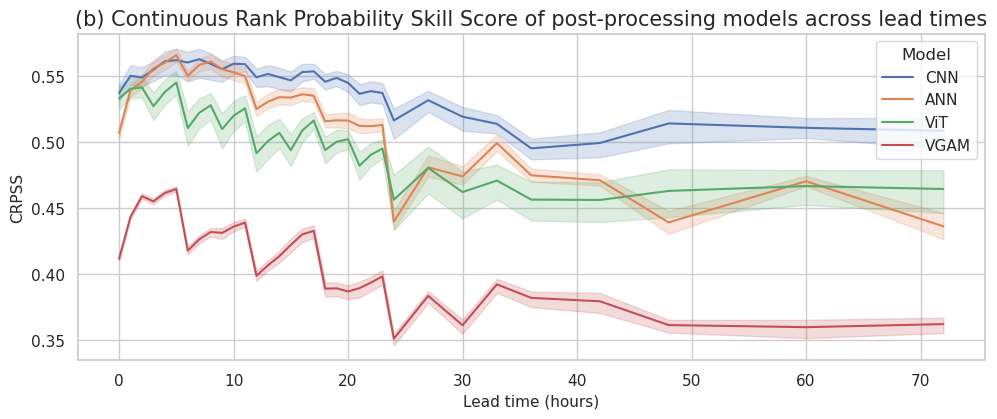

/tmp/ipykernel_3762991/145193318.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gcf().axes[0].set_yticklabels(['Pangu post-processing', 'Direct forecast'])


<Figure size 630x324 with 0 Axes>

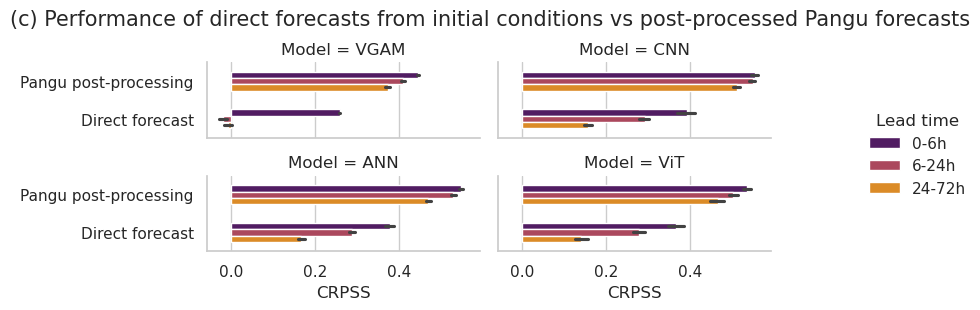

In [6]:
# Plot the CRPSS, with lead time in hours as x-axis

sns.set_theme(style = 'whitegrid')
plt.figure(figsize = (11.7, 4.24))
sns.lineplot(data = crpss_df, x = 'lead_time', y = 'CRPSS', hue = 'Model')
plt.xlabel('Lead time (hours)', fontsize = 11)
plt.ylabel('CRPSS', fontsize = 11)
plt.title('(b) Continuous Rank Probability Skill Score of post-processing models across lead times', fontsize = 15)
plt.tick_params(axis='both', labelsize=11)
plt.show()

# Keep only CNN, ANN, ViT and VGAM
data = crps_pangu_era5[crps_pangu_era5['Model'].isin(['CNN', 'ANN', 'ViT', 'VGAM'])]

sns.set_theme(style = 'whitegrid')
plt.figure(figsize = (6.3, 3.24))
sns.catplot(data = data, kind = 'bar', col = 'Model', x = 'CRPSS', hue = 'Lead time', y = 'Data',
            height = 2.94/2, aspect = 6.3/3.24*1.2, col_wrap = 2, palette = 'inferno', width = 0.5)

#Change y axis label to '' for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('')

# Change y axis ticks labels to 'Pangu post-processing' and 'Direct forecast' for all subplots
plt.gcf().axes[0].set_yticklabels(['Pangu post-processing', 'Direct forecast'])

# set all fonts size to 11
plt.gcf().axes[0].tick_params(axis='both', labelsize=11)

# add suptitle
plt.suptitle('(c) Performance of direct forecasts from initial conditions vs post-processed Pangu forecasts', y = 1.05, fontsize = 15)
plt.show()

Our post-processing models outperform direct forecasts and the climatology of wind gusts across lead times, confirming the added value of Pangu in predicting convective environments and the ability of statistically constrained, data-driven models to make reliable probabilistic wind gusts forecasts. Panel (a) shows the mean CRPSS and its uncertainty ($\pm 1\sigma$) for different models as a function of lead time. Panel (b) shows the mean CRPSS and its uncertainty for different models and different lead times, comparing a direct forecast (obtained with ERA5 initial conditions) to a post-processing of a Pangu forecast.

## Fig 3 : Assessing performance across wind gust speeds

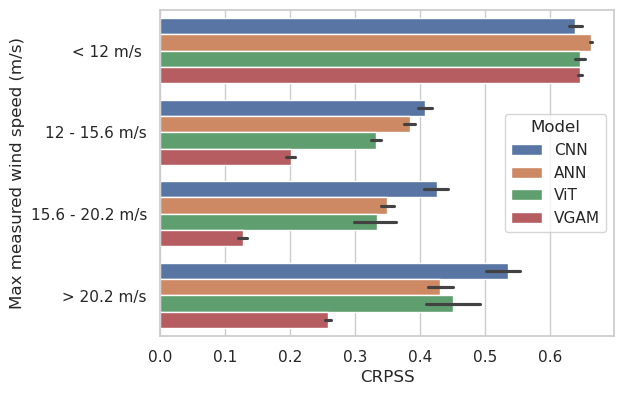

In [7]:
plt.figure(figsize = (5.857, 4.24))
sns.set_theme(style = 'whitegrid')
sns.barplot(crpss_max_winds, x = 'CRPSS', hue = 'Model', y = 'Quantile')
plt.ylabel('Max measured wind speed (m/s)')
plt.tick_params(axis='both', labelsize=11)

The CNN captures extremes better than other models. The panel shows the variation of CRPSS with lead time for all four models for different observed maximum wind gust speeds over the targeted region.

## Fig 4: Shap value analysis

/tmp/ipykernel_3762991/731601744.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


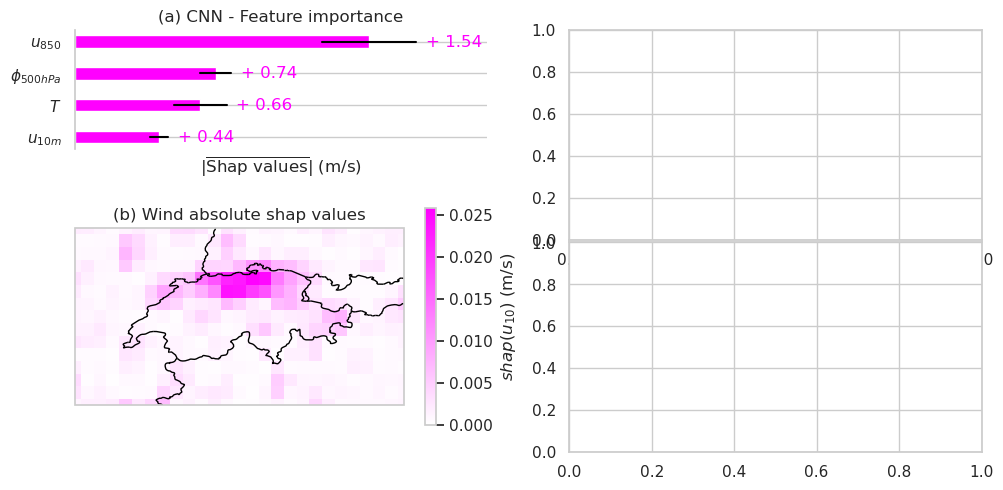

In [ ]:
fig = plt.figure(figsize=(11.7, 5.48))
gs = GridSpec(28, 2, figure=fig)

colors = [(1, 1, 1), (1, 0, 1)]  # White to Magenta
cmap = LinearSegmentedColormap.from_list("white_to_magenta", colors)

ax = fig.add_subplot(gs[:8,0])
# # Feature importance
# fig = plt.figure(figsize=(5.857, 2.24))
shapspatial = [shap_ds[var].sum(dim = ['lon','lat']) for var in ['z_500hPa', 't2m', 'u_850hPa', 'wind']]
ax.barh(range(len(shapspatial)), [i.mean() for i in shapspatial], color = 'magenta', height = 0.4)
# add small horizontal segments at the end of each bar to show the standard deviation
for i, val in enumerate(shapspatial):
    plt.plot([val.mean() - val.std(), val.mean() + val.std()], [i, i], color = 'black')
    plt.text(val.mean() + val.std() + 0.05, i, f"+ {val.mean().values:.2f}", ha = 'left', va = 'center', color = 'magenta')
plt.xlim(0, 2.15)
plt.xlabel(r"$|\overline{\text{Shap values}}| \text{ (m/s)}$")
# add the value of each bar at the right tip of the bar
plt.yticks(range(len(shapspatial)), [r"$u_{10m}$", r"$T$", r"$\phi_{500hPa}$", r"$u_{850}$"] )
plt.title("(a) CNN - Feature importance")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis='x')  # Only show horizontal grid lines
plt.xticks([])
plt.tight_layout()

# fig = plt.figure(figsize=(5.857, 3.24))
proj = ccrs.PlateCarree()
extents = [5.0, 11.5, 45.0, 48.5]
ax = fig.add_subplot(gs[10:,0], projection=proj)
# ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.BORDERS)
ax.set_extent(extents)
vext = shap_ds.wind.mean(dim = 'fold').max()
cbar = shap_ds.wind.mean(dim = 'fold').plot(
    cmap=cmap,
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
    ax=ax,
    vmin=0,
    vmax=vext,
)
plt.title("")
plt.title(f"(b) Wind absolute shap values")
plt.colorbar(
    cbar, orientation="vertical", label=r"$shap(u_{10})$ (m/s)", shrink=0.8, cmap = cmap
)

ax = fig.add_subplot(gs[:14,1])
ax = fig.add_subplot(gs[14:,1])




Near-surface wind speed, near-surface temperature, and wind shear are used across models to predict wind gust distributions over each cluster --- a task for which the CNN primarily focuses on local information. Panel (a) shows the mean absolute SHAP value and its standard deviation for each feature of the CNN, based on a random sample of 50 dates for cluster 1 and for the prediction of the location parameter $\mu$ of wind gusts. Panel (b) shows the mean absolute SHAP value for $u_{10m}$, based on the same samples (black dots represent the stations of cluster 1). Panel (c) represents the VGAM partial dependence plot for the two main predictors for $\mu$ and $\sigma$, along with the univariate distributions of said predictors.